In [74]:
# from google.colab import files
# uploaded = files.upload()

Saving concat_restaurant_hygiene.csv to concat_restaurant_hygiene (1).csv


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../datasets/concat_restaurant_hygiene.csv")

In [3]:
df.shape

(1605, 17)

In [62]:
# from sklearn.preprocessing import OrdinalEncoder
# hygiene_grades = df['GRADE']
# customer_ratings = np.array(df['rating']).reshape(-1, 1)
# enc3 = OrdinalEncoder(categories = [['A', 'B', 'C', 'Z', 'P']]).fit(hygiene_grades.to_numpy().reshape(-1, 1))
# hygiene_grades = enc3.transform(hygiene_grades.to_numpy().reshape(-1, 1))
# hygiene_grades = np.array(hygiene_grades)
# print(type(hygiene_grades[0]))
# print(type(customer_ratings[0]))
# print(hygiene_grades.shape)
# print(customer_ratings.shape)
# correlation = np.corrcoef(hygiene_grades, customer_ratings)
# print("Correlation coefficient:", correlation)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1946, 1)
(1946, 1)


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Correlation coefficient: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


## Correlation test between Yelp rating and hygiene

In [4]:
# Rewrite Correlation

hygiene_grades = df['GRADE'].copy()

revised_grade = []
for each in hygiene_grades:
  if each == 'A':
    revised_grade.append(0)
  elif each == "B":
    revised_grade.append(1)
  elif each == "C":
    revised_grade.append(2)
  elif each == "Z":
    revised_grade.append(3)
  else:
    revised_grade.append(4)


In [5]:
df_corr = df.copy()
df_corr["GRADE_R"] = revised_grade

correlation = df_corr["GRADE_R"].corr(df_corr["rating"])
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.01551520479797473


In [10]:
from sklearn.model_selection import train_test_split
X = df.drop(columns = ['Unnamed: 0', 'rating', 'CAMIS', 'Latitude', 'Longitude', 'SCORE', 'GRADE DATE', 'id', 'name', 'location', 'url', 'ZIPCODE'])
y = df['rating']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=X['GRADE'], random_state = 0)

In [11]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories = [['$', '$$', '$$$', '$$$$']]).fit(X_dev['price'].to_numpy().reshape(-1, 1))
X_dev['price'] = enc.transform(X_dev['price'].to_numpy().reshape(-1, 1))
X_test['price'] = enc.transform(X_test['price'].to_numpy().reshape(-1, 1))

In [12]:
enc2 = OrdinalEncoder(categories = [['A', 'B', 'C', 'Z', 'P']]).fit(X_dev['GRADE'].to_numpy().reshape(-1, 1))
X_dev['GRADE'] = enc2.transform(X_dev['GRADE'].to_numpy().reshape(-1, 1))
X_test['GRADE'] = enc2.transform(X_test['GRADE'].to_numpy().reshape(-1, 1))

In [13]:
from category_encoders import TargetEncoder
te = TargetEncoder(cols = ['CUISINE DESCRIPTION', 'BORO'], handle_unknown='ignore').fit(X_dev, y_dev) 
X_dev_transformed = te.transform(X_dev)
X_test_transformed = te.transform(X_test)

## Correlation Matrix for features of restaurant

<AxesSubplot:>

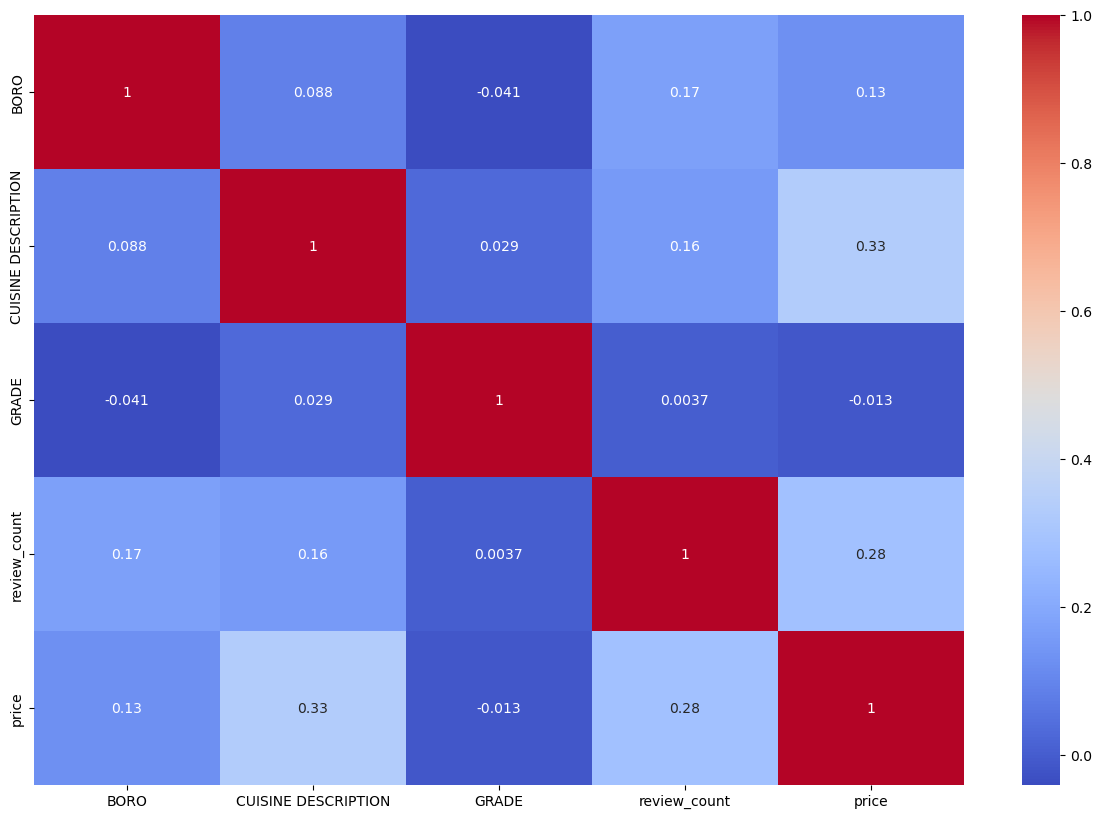

In [15]:
corr_matrix = X_dev_transformed.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 10}, cmap='coolwarm') 

## Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_dev_transformed, y_dev)
y_pred = lr.predict(X_test_transformed)

Intercept: -1.967023051997808
Slope: [ 5.72709314e-01  9.50813210e-01 -2.85474355e-03  1.98655264e-04
  7.11138917e-02]


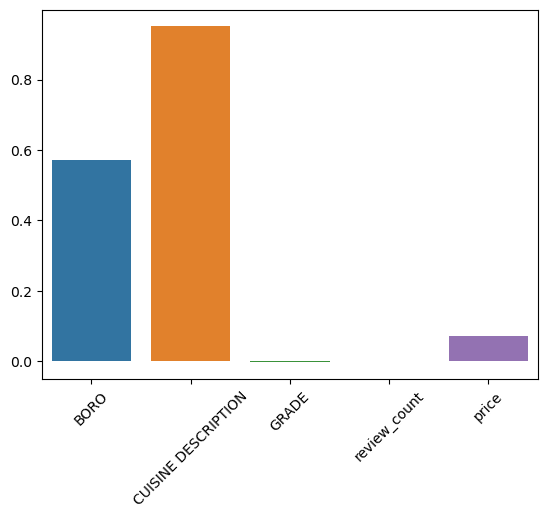

In [17]:
print("Intercept:", lr.intercept_)
print("Slope:", lr.coef_)
ax = sns.barplot(x = X_dev.columns, y = lr.coef_)
ax.tick_params(axis = 'x', rotation = 45)

In [18]:
# R2 and MSE
from sklearn.metrics import r2_score, mean_squared_error
print('R2: ', (r2_score(y_test, y_pred)))
print('MSE: ', mean_squared_error(y_test, y_pred))

R2:  0.20648333891438753
MSE:  0.41381215034244023


In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_dev_transformed, y_dev, cv=5)
print(scores.mean())

0.2362866637292206


## Random Forest

In [20]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_dev_transformed, y_dev)
y_pred_rf = rf_regressor.predict(X_test_transformed)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)


In [21]:
print("MSE: ", mse)
print("R2: ", r2)

MSE:  0.4346175807106541
R2:  0.16658732420198175


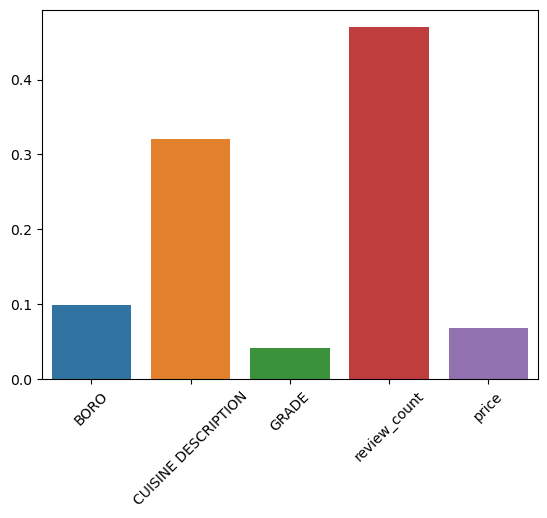

In [23]:
ax2 = sns.barplot(x = X_dev.columns, y = rf_regressor.feature_importances_)
ax2.tick_params(axis = 'x', rotation = 45)